# Main testing

In [1]:
import gym
import minihack
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from typing import Tuple, List
from utils import *
from algorithms import *
from logic import *

## Creazione dell environment

In [2]:
env = gym.make("MiniHack-River-Narrow-v0", observation_keys=("chars", "pixel"))
state = env.reset()
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                            .........@........}                                 
                            ..............`   }                                 
                            ................                                    
                            .. `..............}                                 
                           

In [3]:
state['chars'].shape, state['pixel'].shape

((21, 79), (336, 1264, 3))

In [4]:
game_map = state['chars'].copy()
game = state['pixel']

In [5]:
s,_,_,_ = env.step(0)
new_map = s['chars']
env.render() #Immagine ristretta con range [y][x]


It's solid stone.                                                               
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                            .........@........}                                 
                            ..............`   }                                 
                            ................                                    
                            .. `..............}                                 
                           

In [11]:
are_less_black_blocks_light(get_number_black_blocks(game_map), new_map)

False

## Finding coordinates
Searching for the coordinates of the player, all the boulders and river

In [6]:
start = get_player_location(game_map)
boulders = get_boulder_locations(game_map)
print("Agent position:", start)


Agent position: (11, 37)


Coordinates of each block present in the map

In [7]:
print("Boulders positions: ", boulders)

Boulders positions:  [(10, 32), (10, 33), (10, 37), (10, 38)]


Calcolo la distanza del player dal blocco più vicino

In [8]:
target_block_position, distance = get_min_distance_point_to_points(start[0],start[1],boulders)
print("Target position:", target_block_position, "Distance:", distance)

Target position: [10, 37] Distance: 1


### Finding river positions

In [9]:
river_positions = get_river_locations(game_map)

In [10]:
#Lista con le posizioni del fiume
river_positions

[(8, 44), (9, 44), (10, 44), (11, 44), (12, 44), (13, 44)]

In [11]:
k = get_min_distance_point_to_points(boulders[0][0],boulders[0][1], river_positions)

In [12]:
print(k)

([10, 44], 12)


### Getting the coordinates of the best boulder to push

In [13]:
coordinates_min_boulder = get_best_global_distance(start, boulders, river_positions)
print("Coordinates of the best boulder to push: ",coordinates_min_boulder)
pushing_position = position_for_boulder_push(coordinates_min_boulder, )

[(10, 32, 17), (10, 33, 15), (10, 37, 8), (10, 38, 7)]
Coordinates of the best boulder to push:  (10, 38)


TypeError: position_for_boulder_push() missing 1 required positional argument: 'new_boulder_position'

## Complete path player - boulder - river

1) A star calculates the path from the player to the optimal boulder to push
2) A star calculates the path from the boulder reached to the nearest river position

## Path player to boulder

In [ ]:
path_player_boulder = a_star(game,game_map, start, coordinates_min_boulder, get_optimal_distance_point_to_point)
print("Complete path to reach the target: ",path_player_boulder)

Target found!
Complete path to reach the target:  [(12, 29), (12, 30), (12, 31), (12, 32), (12, 33), (12, 34), (12, 35), (12, 36), (12, 37), (12, 38)]


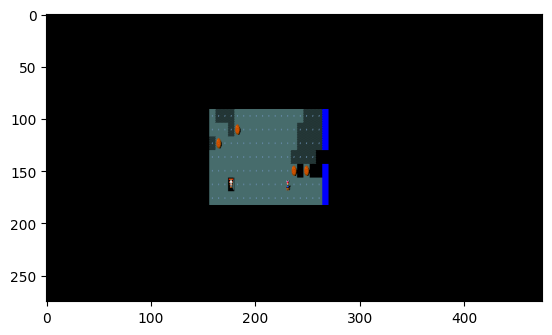

In [ ]:
actions, names = actions_from_path(start, path_player_boulder[1:]) #Remove first action because it is the start position
import time

player_pos = plot_animated_sequence(env,game, game_map,actions)


Printing the actions that the player did to reach the target

In [ ]:
names

['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']

## Path boulder to river

Calculating the coordinates of the shortest distance river position in which the boulder reached has to be dropped

In [ ]:
temp = get_min_distance_point_to_points(coordinates_min_boulder[0],coordinates_min_boulder[1], river_positions)
final_position = tuple(temp[0])


In [ ]:
print("Boulders coordinates:",coordinates_min_boulder[0],coordinates_min_boulder[1],"River position: ", final_position)

path_boulder_river = a_star(game,game_map, coordinates_min_boulder, final_position, get_optimal_distance_point_to_point)
print("Complete path to reach the target: ",path_boulder_river)

Boulders coordinates: 11 39 River position:  (11, 44)
Target found!
Complete path to reach the target:  [(11, 39), (12, 40), (12, 41), (12, 42), (12, 43)]


In [ ]:
get_min_distance_point_to_points(boulders[0][0],boulders[0][1], river_positions)

([8, 44], 14)

In [ ]:
#plt.imshow(state['pixel'][100:250, 400:750]) #Immagine ristretta con range [y][x]

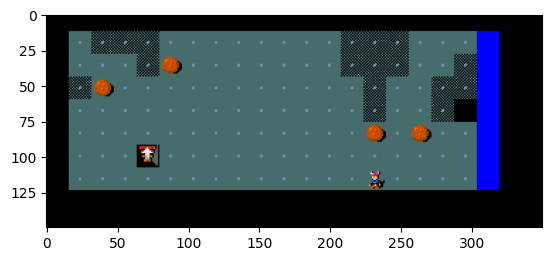

In [ ]:
s,_,_,_ = env.step(5)
plt.imshow(s['pixel'][100:250, 400:750]) #Immagine ristretta con range [y][x]

In [ ]:
print("AGENT: ", get_player_location(state['chars']))
print("BOULDER_PATH: ", path_boulder_river)
agent_actions,agent_path = push_boulder_path(path_boulder_river)

AGENT:  (13, 39)
BOULDER_PATH:  [(11, 39), (12, 40), (12, 41), (12, 42), (12, 43)]
(10, 38) (11, 39)
(12, 39) (12, 40)
(12, 40) (12, 41)
(12, 41) (12, 42)
[(10, 38), (11, 39), (12, 39), (12, 40), (12, 41), (12, 42)]
['SE', 'S', 'E', 'E', 'E'] E


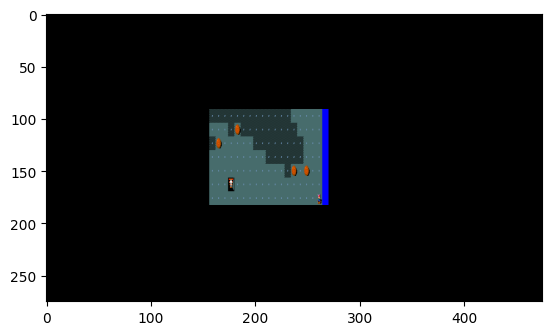

In [ ]:
#actions, names = actions_from_path(start, agent_path) #Remove first action because it is the start position

player_pos = plot_animated_sequence(env,s['pixel'], s['chars'],agent_actions)